In [1]:
!pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
def encode_integers(a, b):
    max_bits = max(a.bit_length(), b.bit_length()) + 1  # extra bit for sign
    a_binary = format(a & int("1" * max_bits, 2), f"0{max_bits}b")
    b_binary = format(b & int("1" * max_bits, 2), f"0{max_bits}b")

    #print("a_binary = ", a_binary)
    #print("b_binary = ", b_binary)

    return a_binary, b_binary


In [3]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram

def create_comparison_oracle(a_binary, b_binary):
    n = max(len(a_binary), len(b_binary))

    # Pad the binary representations with leading zeros to have the same length
    a_binary = a_binary.zfill(n)
    b_binary = b_binary.zfill(n)

    qc = QuantumCircuit(n * 2 + 1)

    for i in range(n):
        if a_binary[-i - 1] == '1':
            qc.x(i)
        if b_binary[-i - 1] == '1':
            qc.x(n + i)

    # Handle sign bits for negative numbers
    qc.cx(0, n)
    qc.cx(n - 1, 2 * n)

    for i in range(1, n):
        qc.cx(i, n + i)

    qc.barrier()

    for i in range(1, n - 1):
        qc.ccx(n + i, n + i + 1, 2 * n)

    # Add extra handling for negative numbers
    qc.cx(0, n)
    qc.cx(n - 1, 2 * n)
    qc.ccx(n - 1, 0, 2 * n)

    qc.barrier()

    for i in range(1, n):
        qc.cx(i, n + i)

    # Add a final CNOT gate to handle the sign bit difference
    qc.cx(0, 2 * n)

    return qc


In [4]:
def create_diffuser(n):
    qc = QuantumCircuit(n)

    # Apply transformation |s> -> |00..0> (H-gates)
    qc.h(range(n))
    # Apply transformation |00..0> -> |11..1> (X-gates)
    qc.x(range(n))
    # Do multi-controlled-Z gate
    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)  # multi-controlled-toffoli
    qc.h(n-1)
    # Apply transformation |11..1> -> |00..0>
    qc.x(range(n))
    # Apply transformation |00..0> -> |s>
    qc.h(range(n))

    # Convert to a gate and return
    diffuser = qc.to_gate()
    diffuser.name = "U$_s$"

    return diffuser

In [5]:
def custom_measure(qc, a_qubits, b_qubits, ancilla_qubit, classical_register):
    # Measure the ancilla qubit
    qc.measure(ancilla_qubit, classical_register[0])

    # Measure a's register if ancilla is |1>
    for i, qubit in enumerate(a_qubits):
        qc.measure(qubit, classical_register[i + 1]).c_if(classical_register[0], 1)

    # Measure b's register if ancilla is |0>
    for i, qubit in enumerate(b_qubits):
        qc.measure(qubit, classical_register[i + 1]).c_if(classical_register[0], 0)


def run_grover(a, b, num_iterations):
    a_binary, b_binary = encode_integers(a, b)
    
    comparison_oracle = create_comparison_oracle(a_binary, b_binary)
    n = comparison_oracle.num_qubits - 1

    diffuser = create_diffuser(n)

    '''
    The output histogram's x-axis shows 5 qubits instead of 4 because the custom measurement function 
    is designed to measure the ancilla qubit and the larger integer's qubits.

    The ancilla qubit indicates which integer is larger (|1⟩ for a > b and |0⟩ for b > a), 
    and the following 4 qubits represent the larger integer.
    '''
    qc = QuantumCircuit(n + 1, 5)

    qc.append(comparison_oracle, range(n + 1))
    for _ in range(num_iterations):
        qc.append(diffuser, range(n))
        qc.append(comparison_oracle, range(n + 1))
    
    # Use the custom measurement function
    custom_measure(qc, [0, 1, 2], [3, 4, 5], n, qc.clbits)

    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=1000)
    result = job.result()
    counts = result.get_counts(qc)
    return counts

In [6]:
from tqdm import tqdm

def run_grover_multiple_times(a, b, num_iterations, num_runs):
    aggregated_counts = {}
 
    for _ in tqdm(range(num_runs)):
        counts = run_grover(a, b, num_iterations)
        for key, value in counts.items():
            if key in aggregated_counts:
                aggregated_counts[key] += value
            else:
                aggregated_counts[key] = value
                
    return aggregated_counts

In [7]:
import matplotlib.pyplot as plt

def plot_histogram_vertical_labels(data, **kwargs):
    # Extract labels and counts from the data
    labels = list(data.keys())
    counts = list(data.values())
    
    # Create the bar plot
    fig, ax = plt.subplots()
    bars = ax.bar(labels, counts, **kwargs)

    # Rotate the x-axis labels to be displayed vertically
    plt.setp(ax.get_xticklabels(), rotation='vertical', fontsize=8)

    # Display the counts above the bars, rotated vertically
    for bar, count in zip(bars, counts):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                str(count), ha='center', va='bottom', rotation='vertical', fontsize=8)

    # Show the plot
    plt.show()

    # Finds the most probable value after aggregrated runs
    highest_count_key = max(data, key=data.get)
    highest_count_value = data[highest_count_key]

    print("Highest count label:", highest_count_key)
    print("Highest count value:", highest_count_value)

    return highest_count_key
    

N is the size of the search space and M is the number of solutions

See https://qiskit.org/documentation/tutorials/algorithms/06_grover.html#The-number-of-iterations

the search space size is 2^4 = 16, and there is only one solution (00011). Therefore, the optimal number of iterations should be around:

In [8]:
import math
from qiskit.algorithms import Grover

a = -5
b = -6

max_bits = max(a.bit_length(), b.bit_length()) + 1  # extra bit for sign
#print("max_bits = ", max_bits)

N = 2**max_bits
M = 1  # because we are selecting the larger integer between a and b, so only 1 solution

# Subtracts 1 to account for the zero-indexed iteration count.
optimal_iterations = Grover.optimal_num_iterations(num_solutions=M, num_qubits=max_bits) - 1  # int(math.floor((math.pi / 4) * math.sqrt(N / M))) - 1
print("optimal_iterations = ", optimal_iterations)

optimal_iterations =  2


100%|██████████| 100/100 [00:05<00:00, 17.31it/s]


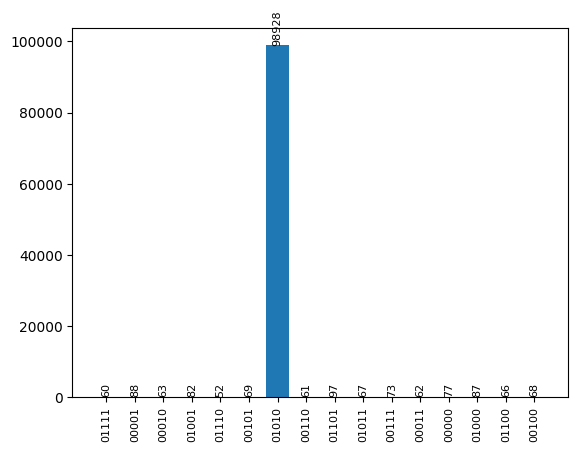

Highest count label: 01010
Highest count value: 98928


In [9]:
num_iterations = optimal_iterations

num_runs = 100
counts = run_grover_multiple_times(a, b, num_iterations, num_runs)

# Use the custom function with aggregated_counts
highest_count_key = plot_histogram_vertical_labels(counts)

In [10]:
def twos_complement_to_normal(binary_str):
    bits = len(binary_str)
    num = int(binary_str, 2)

    # Check if the number is negative
    if (num & (1 << (bits - 1))) != 0:
        num = -(~num + 1 & ((1 << bits) - 1))

    # Get the absolute value and convert back to binary string
    return bin(abs(num))[2:]


def decode_output(output, a_binary, b_binary):
    comparison_bit = output[0]
    encoded_result = output[1:]
    if comparison_bit == '0':
        larger_encoded = b_binary
    else:
        larger_encoded = a_binary

    if larger_encoded[0] == '1':  # Negative number
        larger_encoded = twos_complement_to_normal(larger_encoded[1:])
        decoded_result = -int(larger_encoded, 2)
    else:
        decoded_result = int(larger_encoded[1:], 2)

    return decoded_result


output = highest_count_key
a_binary, b_binary = encode_integers(a, b)
decoded_result = decode_output(output, a_binary, b_binary)
print("decoded_result = ", decoded_result)


decoded_result =  -2
